In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans

In [2]:
def logistic_regression(x, y):
    try:
        X = np.transpose([np.ones(len(x)), x])
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        return (model_fit.prsquared, model_fit)
    except np.linalg.LinAlgError:
        return (0, None)
    except sm.tools.sm_exceptions.PerfectSeparationError:
        return (1, None) # Data is linearly separable

def sample_trials(alevel_idxs, n_samples):
    trial_per_alevel = 500
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * trial_per_alevel
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return np.array(random.sample(trials_to_sample, n_samples))

In [3]:
def get_data(data_dir):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 200

    s_trial = 0
    t_trial = 4000
    n_trials = t_trial - s_trial

    rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
    task_input = np.zeros((2, n_trials))
    v1v2_values = np.zeros((2, n_trials))
    wPFC_output = np.zeros((n_trials, N_OUTPUT_NEURONS, N_PFC_NEURONS))

    for i in range(s_trial, t_trial):
        with open(data_dir + "/" + str(i) + ".json") as json_file:
            data = json.load(json_file)
            idx = i - s_trial

            rPFC = np.array(data["network_rates"]["r_PFC"])
            rPFC_trials[idx,:,:] = rPFC

            trial_task_input = np.array(data["trial_data"]["input"])
            task_input[:,idx] = trial_task_input[:2]
            v1v2_values[:,idx] = trial_task_input[2:4]
            
            wPFC_output[idx,:,:] = np.array(data["network_weights"]["w_outputs"])

    return (rPFC_trials, task_input, v1v2_values, wPFC_output)

def get_trials(v1v2_values):
    TRIAL_SAMPLE_SIZE = 300
    N_PFC_NEURONS = 500

    # Block schedule ['30', '90', '10', '90', '70', '30', '10', '70']
    alevel_90_idxs = [1,3]
    alevel_10_idxs = [2,6]
    alevel_70_idxs = [4,7]
    alevel_30_idxs = [0,5]

    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented

    alevel_90_trials = sample_trials(alevel_90_idxs, TRIAL_SAMPLE_SIZE)
    alevel_10_trials = sample_trials(alevel_10_idxs, TRIAL_SAMPLE_SIZE)
    alevel_70_trials = sample_trials(alevel_70_idxs, TRIAL_SAMPLE_SIZE)
    alevel_30_trials = sample_trials(alevel_30_idxs, TRIAL_SAMPLE_SIZE)
    
    match_trials = np.concatenate((alevel_90_trials, alevel_70_trials))
    nonmatch_trials = np.concatenate((alevel_10_trials, alevel_30_trials))
#     match_trials = alevel_90_trials
#     nonmatch_trials = alevel_10_trials
    trials = np.concatenate((match_trials, nonmatch_trials))
    
    match_trials = match_trials[v1v2_values[0,match_trials] >= 0.6]
    nonmatch_trials = nonmatch_trials[v1v2_values[0,nonmatch_trials] <= 0.4]
    trials = np.concatenate((match_trials, nonmatch_trials))
    
    return (match_trials, nonmatch_trials, trials)

def score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 250
    
    CUE_TIME = 100
    
    cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = CUE_TIME
    
    cue_match = task_input[0, match_trials]
    cue_nonmatch = task_input[0, nonmatch_trials]
    
    rsquareds = np.empty((N_PFC_NEURONS, 2))
    rsquareds[:] = np.nan
    
    for neuron_idx in range(0,N_PFC_NEURONS): #range(1,N_PFC_NEURONS):
        fr_match = np.mean(rPFC_trials[match_trials, cuetime_s:cuetime_t, neuron_idx],1)
        fr_nonmatch = np.mean(rPFC_trials[nonmatch_trials, cuetime_s:cuetime_t, neuron_idx],1)
        
        (r2_match, model_fit_match) = logistic_regression(fr_match, cue_match)
        (r2_nonmatch, model_fit_nonmatch) = logistic_regression(fr_nonmatch, cue_nonmatch)
        r2_match = 0 if r2_match < 0 else r2_match
        r2_nonmatch = 0 if r2_nonmatch < 0 else r2_nonmatch
            
        rsquareds[neuron_idx,:] = [r2_match, r2_nonmatch]
        
    return rsquareds

In [4]:
(rPFC_trials, task_input, v1v2_values, wPFC_output) = get_data("/om2/group/halassa/PFCMD-ali-sabrina/MD_on_2/by_trial")
(rPFC_trials_noMD, task_input_noMD, v1v2_values_noMD, wPFC_output_noMD) = get_data("/om2/group/halassa/PFCMD-ali-sabrina/MD_off_2/by_trial")


In [5]:
(match_trials, nonmatch_trials, trials) = get_trials(v1v2_values)

In [6]:
scores = score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials)
scores_noMD = score_cue_like(rPFC_trials_noMD, task_input_noMD, match_trials, nonmatch_trials)


Optimization terminated successfully.
         Current function value: 0.110507
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.608144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.067274
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.685885
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.154121
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.597357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.165827
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.288731
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.355235
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.476522
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.480719
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.545977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522939
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.659108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.336755
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691539
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.547711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490269
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.008048
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.180795
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.640941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339196
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.214037


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.582967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.221917
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.472357
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.664595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.233147
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692924
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.360623
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.048081
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692314
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686904
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011215
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.399283
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.244938
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.536067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353802
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.101128
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.200645
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.346413
         Iterations 9
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.643926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.191897
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689074
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.146719
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.533998
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.212587
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.582590
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396767
         Iterations 7
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.211592
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.605007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.693067
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688306
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.235057
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.668463
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.538272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.661216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.676423
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.595556
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.075044
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.683025
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.452189
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.021140
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.676551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666868
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690747
         Iterations 4
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.675058
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.664461
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128890
         Iterations 9
         Current function value: 0.000976
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.644574
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.384143
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.089282
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.027375
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.043574
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.146908
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.363770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.607284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468476
         Iterations 6
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.152684
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.669926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.691562
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.512088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.230578
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.478164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.461379
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.052369
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.623954

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.574204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564345
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.041187
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.589891
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.485526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.151561
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.632116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692710
         Iterations 4
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048001
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.438296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.214705
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.159105
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.618189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398551
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.626741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678854
         Iterations 4
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.414563
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.036338
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.509220
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.099853
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.153901
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.638137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.101928
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.616333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.690551
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.28164

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.237146
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.210042
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.304121
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.570849
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.668829
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.439401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689801
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690739
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.154194
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.316037
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.545792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.548934
         Iterations 5
Optimization termina

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.667760
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.621296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633056
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.170646
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.485406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691450
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.628411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642329
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597467
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.288987
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.131558
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.092963
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.672817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.093866
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.681534
         Iterations 5
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.597182
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.466662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.292323
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692319
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.380103
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.244228
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.628615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.685009
         Iterations 4
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.194707
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.529840
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.257984
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.089864
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.404368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.572359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688742
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.509188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.008720
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.308355


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.478795
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382144
         Iterations 7
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.489178
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689730
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.499654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500198
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.576953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.240600
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.642439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.314804
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.140494
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.562032
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.550659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381790
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.294136
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.270837
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.112897
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.566976
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.286136
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691160
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689795
         Iterations 4
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.434726
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.606896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.189060
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.041746
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.527896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689853
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.514141
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.571480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430155
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.339192
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.143403
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.172295
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.640687
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.314677
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.287805
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.018349
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.607064
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.634252
         Iterations 6
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682236
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.561197
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.558410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690406
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.520681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.657662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.237693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.159708
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.031633
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692684
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.670230
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.459821
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691908
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689912
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.498520
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.294967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.648499
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.556300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.071372
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.145659
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.253501
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690801
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.229984
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.562377
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035430
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.676632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.171624
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.661150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.018792
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.691484
         Iterations 4
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.684751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.012948
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.044278
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.654553
         Iterations 5
         Current function value: 0.125427
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.361987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380899
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.020333
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.323804
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.340489
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.690558
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.225902
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.673580
         Iterations 5
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.211084
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.563704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679817
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.293632
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.195218
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.647711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.322557
  

Optimization terminated successfully.
         Current function value: 0.610456
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.497078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402160
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.663386
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682431
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.020500
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.006518
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693072
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692474
         Iterations 4
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.645732
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.233626
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.620773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.630720
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.266125
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.006794
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.602146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.328059
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.523863
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690137
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.429558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.167691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.692354
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680560
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.331119
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.250298
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692732
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.481517
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.461007
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.608897
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.677068
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.263189
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.523282
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.688384
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691769
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.536651
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.553172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536928
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.651790
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.693072
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.692819
         Iterations 4
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.330173
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.677786
         Iterations 5
         Current function value: 0.165817
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.329705
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.174370
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.574211
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.336728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.580389
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.606853
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.674432
         Iterations 4
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.107776
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.614052
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.678847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.230189
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.426430
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.534574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.631975
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.672332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.244236
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682480
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543756
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.290037
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.681259
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.193354
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.667048
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.661712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608966
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.686685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479431
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663465
         Iterations 4
         Current function value: 0.597946
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693028
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693072
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.687401
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.492156
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.191189
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.614135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.424484
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.118557
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.007931
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.577061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341219
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025813


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.639138
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.303698
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.018964
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.670652
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.618969
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006454
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.638759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.016622
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.637809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671012
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.031949
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.306161
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014426
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.026400
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.333800
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.474171
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.215317
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689468
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693009
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.636377
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.440863
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052627
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.566998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.691864
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.558879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.011600
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.388788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341527
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.634631
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.003642
         Iterations 18
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021636
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.392474
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.348888
         Iterations 13
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.430118
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.318548
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016156
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.590344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.549647
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023287
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.683088
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678288
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053613
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.662953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.157947
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.083649
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.689386
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692438
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.503846
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.024445
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.203055
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.342253
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369795
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.363660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370772
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.275695
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682233
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.010715
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.029613
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.335311
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.510155
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.580516
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.618094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.041093
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.391105
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.412432
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565474
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000548
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074301
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.692959
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.120098
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.277686
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026559
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691920
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692991
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.443028
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022569
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049275
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.444879
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683240
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.492929
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.022911
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.045236
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.692940
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.027231
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028799
         Iterations 13
         Current function value: 0.532422
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.339723
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011210
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.537295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006025
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.088659
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.075081
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.559333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.019459
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.170276
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.538302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.193479
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.511229
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.217721
         Iterations 9
         Current function value: inf
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.225320
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.005150
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.079166
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.675756
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.182250
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.077505
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686727
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.619825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.089073
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.666945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.197627
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.526002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.023479
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.313460
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.379315
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006349
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.141096
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.152708
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.650934
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.259312
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.670797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.022142
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.149078
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.011267
         Iterations 14
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.536585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.176115
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692705
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.547595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.122781
         Iterations 10
Optimization 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.133527
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.679724
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682757
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.020003
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.012667
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.271357
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.048603
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018976
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022564
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.476602
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.278667
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.664639
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.317202
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682096
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146387
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.273090
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.691776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.569068
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.569101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.632396
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.223026
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693015
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.672905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.590170
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.258285
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.140556
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.005020
         Iterations 16
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008615
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005433
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.492574
         Iterat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.363812
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.052298
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.044928
         Iterations 12
         Current function value: 0.000154
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070873
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.607661
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187486
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.308765
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.021371
         Iterations 13
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.150274
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.692871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488438
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.011999
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.664614
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.566881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.158415
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.417113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.445678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.611609

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.464060
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.520332
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.626512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688597
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.278602
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.618320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689966
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.634314
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
         Current function value: inf
         Iterations:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.023031
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.150534
         Iterations 9
         Current function value: 0.000368
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.384047
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017224
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.692992
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.067333
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.413525
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.637345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.043227
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.616934
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.481494
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337169
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.208774
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.057443
         Iterations 11
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.656811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.311515
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010345
         Iterations 14
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.004633
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.620746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564518
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690179
         Iterations 4
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.677830
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.113254
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.107653
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.401175
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657871
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.004934
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.019918
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179543
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.680193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.560978
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022153
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.325665
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.015580
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.206914
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.183874
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.120005
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.010226
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613728
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.541128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.030003
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.692693
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.065914
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.570059
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.145604
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.126188
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.338420
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.390282
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.330723
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689588
         Iterations 4
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.591975
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.052561
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.145186
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.663705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687908
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.020748
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065420
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668743
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.286044
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685156
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.082655
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.046447
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690123
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.680844
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.052246
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.212118
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.666380
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.604696
         Iterations 8
Optimization termi

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.568648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.622078
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.129120
         Iterations 10
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024372
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.210079
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.643648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.236372
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.286256
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.646532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.078768
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.472075
         Iterations 6
         Current function value: 0.691830
         Iterations: 50
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.018085
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.143359
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690825
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.575896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.185422
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.574454
         Iterations 6
         Current function value: 0.020684
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.552078
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.690168
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.343459
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.424643
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.395989
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080226
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.291198
         Iterations 8
Optimization terminated successfully.
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.211654
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.072336
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.690974
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.616619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510451
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.438959
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.648108
         Iterations 7
         Current function value: 0.187946
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006164
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.006953
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.056347
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.030023
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.611520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.207766
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.679355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609333
         Iterations 5
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.319312
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091578
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.525113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355229
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671418
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013572
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.486682
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.003010
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.609663
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.279662
         Iterations 8
         Current function value: 0.691811
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.288451
         Iterations 9
         Current function value: 0.486636
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.162608
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067066
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.637657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.003715
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.142605
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.693027
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.277987
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.081280
         Iterations 10
         Current function value: 0.473900
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693016
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.305840
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.610061
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.267836
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.378132
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143667
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685138
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.626376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.059896
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.104669
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.649713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491936
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693028
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.013830
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023760
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.093531
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.518124
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024737
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.657537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.652938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.654297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548890
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009811
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.627176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.462143
         Iterations 6
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.011673
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.232112
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.067583
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.024618
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.664986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681699
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.141847
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.597141
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244186
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.237283
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.029882
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.457979
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.471830
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.095426
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692512
         Iterations 3
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049389
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.016086
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.282639
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013827
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.077645
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.673764
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.478820
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669916
         Iterations 5
         Current function value: 0.037143
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.663281
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.050120
         Iterations 11
         Current function value: 0.680635
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693028
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.608857
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585858
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693028
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691873
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.025604
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.632046
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.659305
         Iterations: 50
         Current function value: 0.888130
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.283563
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.691811
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.581966
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693072
         Iterations 3


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691811
         Iterations 45
Optimization terminated successfully.
         Current function value: 0.192913
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684807
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.721986
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036206
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.676009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399241
         Iterations 8
Optimization terminated successfully.


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.687751
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693072
         Iterations 3
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693072
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685948
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027935
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.314589
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.673708
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.620511
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165736
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.034672
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.566484
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.616354
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.290951
         Iterations 8
         Current function value: 0.690591
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693028
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.671506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.442931
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342368
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.605345
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.281003
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.659672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390071
         Iterations 13
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054719
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.412762
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693072
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.652697
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683773
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639136
         Iterations 5
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.067300
         Iterations 19
         Current function value: 0.691811
         Iterations: 50
         Current function value: 0.399764
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024598
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693072
         Iterations 3
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.496777
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.143793
         Iterations 15
         Current function value: 0.000006
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.675394
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.691073
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.683565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.049523
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.238357
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.022634
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.104290
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.106850
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.044841
         Iterations 12
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.601931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666848
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.294676
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.056581
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.146492
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.351557
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.162268
         Iterations 9
         Current function value: 0.662391
         Iterations: 50
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.251848
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.004101
         Iterations 17
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124107
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.152577
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.110952
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.494067
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.691811
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.0

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000336
         Iterations: 50
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013214
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.571435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.446186
         Iterations 7


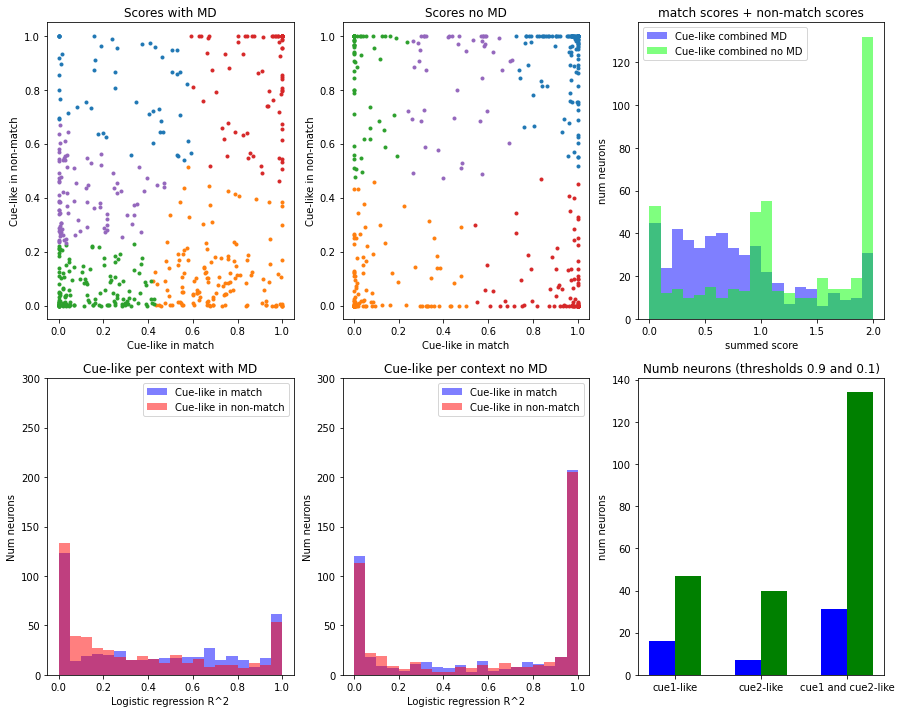

In [7]:
def plot_kmeans(ax, X):
    model = KMeans(n_clusters=5)
    model.fit(X)
    yhat = model.predict(X)
    clusters = np.unique(yhat)
    for cluster in clusters:
        row_ix = np.where(yhat == cluster)
        ax.scatter(X[row_ix, 0], X[row_ix, 1], marker=".")

fig = plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(2,3,1)
plot_kmeans(ax1, scores)
ax1.set_xlabel("Cue-like in match")
ax1.set_ylabel("Cue-like in non-match")
ax1.set_title("Scores with MD")

ax2 = fig.add_subplot(2,3,4)
ax2.hist(scores[:,0], bins=20, fc=(0, 0, 1, 0.5), label="Cue-like in match")
ax2.hist(scores[:,1], bins=20, fc=(1, 0, 0, 0.5), label="Cue-like in non-match")
ax2.legend()
ax2.set_title("Cue-like per context with MD")
ax2.set_xlabel("Logistic regression R^2")
ax2.set_ylabel("Num neurons")
ax2.set_ylim((0,300))

ax3 = fig.add_subplot(2,3,2)
plot_kmeans(ax3, scores_noMD)
ax3.set_xlabel("Cue-like in match")
ax3.set_ylabel("Cue-like in non-match")
ax3.set_title("Scores no MD")

ax4 = fig.add_subplot(2,3,5)
ax4.hist(scores_noMD[:,0], bins=20, fc=(0, 0, 1, 0.5), label="Cue-like in match")
ax4.hist(scores_noMD[:,1], bins=20, fc=(1, 0, 0, 0.5), label="Cue-like in non-match")
ax4.legend()
ax4.set_title("Cue-like per context no MD")
ax4.set_xlabel("Logistic regression R^2")
ax4.set_ylabel("Num neurons")
ax4.set_ylim((0,300))

ax5 = fig.add_subplot(2,3,3)
ax5.hist(np.add(scores[:,0], scores[:,1]), bins=20, fc=(0, 0, 1, 0.5), label="Cue-like combined MD")
ax5.hist(np.add(scores_noMD[:,0], scores_noMD[:,1]), bins=20, fc=(0, 1, 0, 0.5), label="Cue-like combined no MD")
ax5.legend()
ax5.set_title("match scores + non-match scores")
ax5.set_xlabel("summed score")
ax5.set_ylabel("num neurons")

ax6 = fig.add_subplot(2,3,6)
num_cue1_MD = len(np.where(np.logical_and(scores[:,0] > 0.9, scores[:,1] < 0.1))[0])
num_cue2_MD = len(np.where(np.logical_and(scores[:,1] > 0.9, scores[:,0] < 0.1))[0])
num_cue_MD  = len(np.where(np.logical_and(scores[:,0] > 0.9, scores[:,1] > 0.9))[0])
num_cue1_noMD = len(np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0])
num_cue2_noMD = len(np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0])
num_cue_noMD  = len(np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] > 0.9))[0])
w = 0.3
x = np.arange(3)
plt.xticks(x, ["cue1-like", "cue2-like", "cue1 and cue2-like"])
ax6.bar(x-w/2, [num_cue1_MD, num_cue2_MD, num_cue_MD], width=w, color="blue")
ax6.bar(x+w/2, [num_cue1_noMD, num_cue2_noMD, num_cue_noMD], width=w, color="green")
ax6.set_ylabel("num neurons")
ax6.set_title("Numb neurons (thresholds 0.9 and 0.1)")

plt.show()

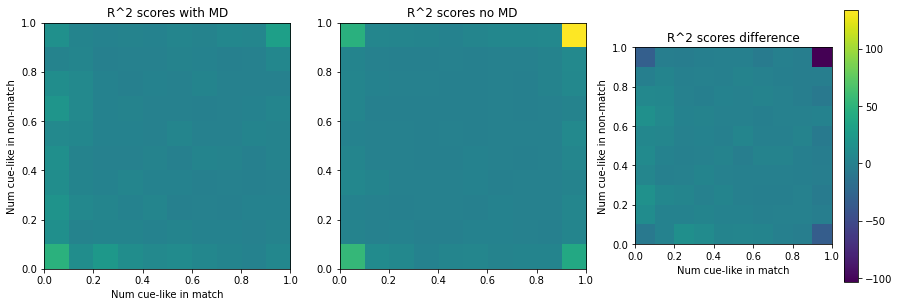

In [8]:
fig = plt.figure(figsize=(15,5))

H1, xedges, yedges = np.histogram2d(scores[:,0], scores[:,1], bins=10)
H2, _, _ = np.histogram2d(scores_noMD[:,0], scores_noMD[:,1], bins=10)
H3 = np.subtract(H1, H2)

vmax = max(np.max(H1),np.max(H2))
vmin = np.min(H3)

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(H1, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax1.set_title("R^2 scores with MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(H2, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax2.set_title("R^2 scores no MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax3 = fig.add_subplot(1,3,3)
im = ax3.imshow(H3, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax3.set_title("R^2 scores difference")
ax3.set_xlabel("Num cue-like in match")
ax3.set_ylabel("Num cue-like in non-match")

fig.colorbar(im)

plt.show()

[  1  34  55  73 101 113 305 345 355 365 408 435 453]
(4000, 2, 500)
(583, 94)
(94, 484)


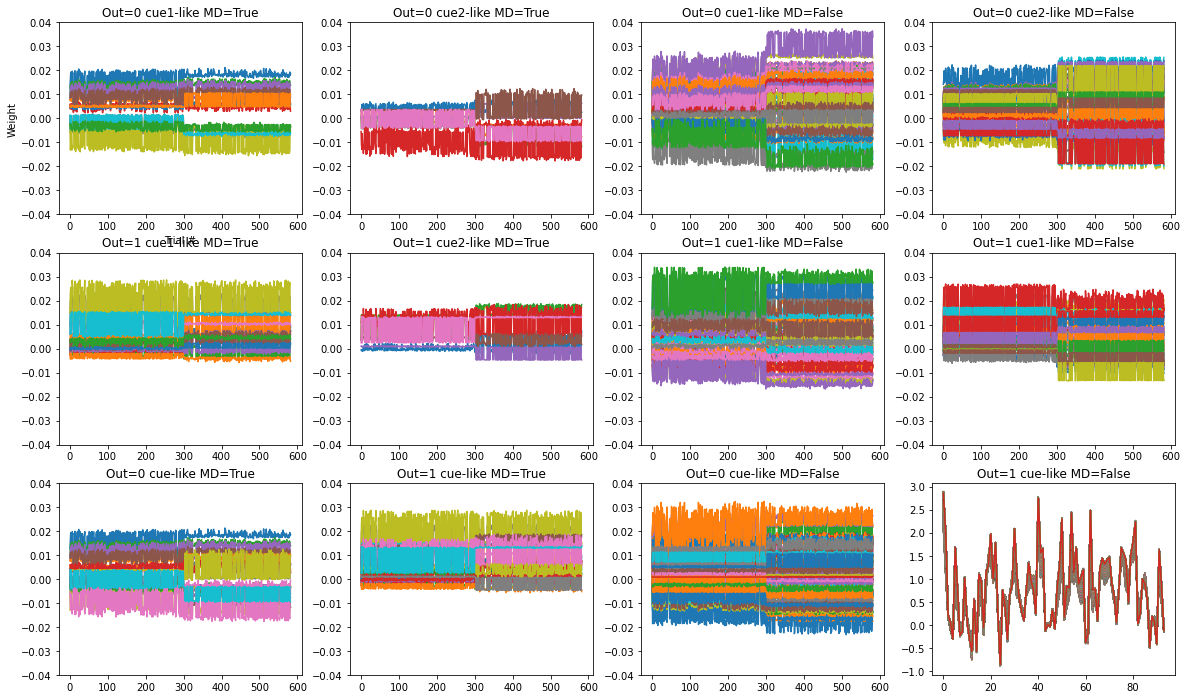

In [30]:
cue1_MD_idxs    = np.where(np.logical_and(scores[:,0] > 0.9, scores[:,1] < 0.1))[0]
cue2_MD_idxs    = np.where(np.logical_and(scores[:,1] > 0.9, scores[:,0] < 0.1))[0]
cuelike_MD_idxs = np.concatenate((cue1_MD_idxs, cue2_MD_idxs))
cue1_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0]
cue2_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0]
cuelike_noMD_idxs = np.concatenate((cue1_noMD_idxs, cue2_noMD_idxs))

x = np.arange(0,4000)
wPFC_out0_all = wPFC_output[match_trials,0,:]
wPFC_out1_all = wPFC_output[match_trials,1,:]
wPFC_out0_all_noMD = wPFC_output_noMD[match_trials,0,:]
wPFC_out1_all_noMD = wPFC_output_noMD[match_trials,1,:]

m0 = np.mean(wPFC_out0_all,1)
m1 = np.mean(wPFC_out1_all,1)
e0 = np.std(wPFC_out0_all,1) / math.sqrt(wPFC_out0_all.shape[1])
e1 = np.std(wPFC_out1_all,1) / math.sqrt(wPFC_out1_all.shape[1])

m0_noMD = np.mean(wPFC_out0_all_noMD,1)
m1_noMD = np.mean(wPFC_out1_all_noMD,1)
e0_noMD = np.std(wPFC_out0_all_noMD,1) / math.sqrt(wPFC_out0_all_noMD.shape[1])
e1_noMD = np.std(wPFC_out1_all_noMD,1) / math.sqrt(wPFC_out1_all_noMD.shape[1])

print(cue1_MD_idxs)
print(wPFC_output.shape)

wPFC_out0_cue1_MD = wPFC_output[:,0,cue1_MD_idxs]
wPFC_out0_cue1_MD = wPFC_out0_cue1_MD[match_trials,:]
wPFC_out1_cue1_MD = wPFC_output[:,1,cue1_MD_idxs]
wPFC_out1_cue1_MD = wPFC_out1_cue1_MD[match_trials,:]

wPFC_out0_cue2_MD = wPFC_output[:,0,cue2_MD_idxs]
wPFC_out0_cue2_MD = wPFC_out0_cue2_MD[match_trials,:]
wPFC_out1_cue2_MD = wPFC_output[:,1,cue2_MD_idxs]
wPFC_out1_cue2_MD = wPFC_out1_cue2_MD[match_trials,:]

wPFC_out0_cuelike_MD = wPFC_output[:,0,cuelike_MD_idxs]
wPFC_out0_cuelike_MD = wPFC_out0_cuelike_MD[match_trials,:]
wPFC_out1_cuelike_MD = wPFC_output[:,1,cuelike_MD_idxs]
wPFC_out1_cuelike_MD = wPFC_out1_cuelike_MD[match_trials,:]

wPFC_out0_cue1_noMD = wPFC_output_noMD[:,0,cue1_noMD_idxs]
wPFC_out0_cue1_noMD = wPFC_out0_cue1_noMD[match_trials,:]
wPFC_out1_cue1_noMD = wPFC_output_noMD[:,1,cue1_noMD_idxs]
wPFC_out1_cue1_noMD = wPFC_out1_cue1_noMD[match_trials,:]

wPFC_out0_cue2_noMD = wPFC_output_noMD[:,0,cue2_noMD_idxs]
wPFC_out0_cue2_noMD = wPFC_out0_cue2_noMD[match_trials,:]
wPFC_out1_cue2_noMD = wPFC_output_noMD[:,1,cue2_noMD_idxs]
wPFC_out1_cue2_noMD = wPFC_out1_cue2_noMD[match_trials,:]

wPFC_out0_cuelike_noMD = wPFC_output[:,0,cuelike_noMD_idxs]
wPFC_out0_cuelike_noMD = wPFC_out0_cuelike_noMD[match_trials,:]
wPFC_out1_cuelike_noMD = wPFC_output[:,1,cuelike_noMD_idxs]
wPFC_out1_cuelike_noMD = wPFC_out1_cuelike_noMD[match_trials,:]

# fig = plt.figure(figsize=(15,12))

# ax1 = fig.add_subplot(2,2,1)
# ax1.plot(x, np.mean(wPFC_out0_all,1), color=(0,0,1,0.4), label="Out=0 all")
# ax1.fill_between(x, m0-e0, m0+e0, color=(0,0,1,0.1))
# ax1.plot(x, np.mean(wPFC_out1_all,1), color=(1,0,0,0.4), label="Out=1 all")
# ax1.fill_between(x, m1-e1, m1+e1, color=(1,0,0,0.1))
# ax1.plot(x, np.mean(wPFC_out0_cue1_MD,1), color=(0,1,1), label="Out=0 cue1-like")
# ax1.plot(x, np.mean(wPFC_out1_cue1_MD,1), color=(1,0,1), label="Out=1 cue1-like")
# ax1.set_ylim((-.001,.010))
# ax1.set_xlabel("Trial #")
# ax1.set_ylabel("Weight")
# ax1.set_title("wPFC Cue=1 MD=True")
# ax1.legend()

# ax2 = fig.add_subplot(2,2,2)
# ax2.plot(x, np.mean(wPFC_out0_all,1), color=(0,0,1,0.4), label="Out=0 all")
# ax2.fill_between(x, m0-e0, m0+e0, color=(0,0,1,0.1))
# ax2.plot(x, np.mean(wPFC_out1_all,1), color=(1,0,0,0.4), label="Out=1 all")
# ax2.fill_between(x, m1-e1, m1+e1, color=(1,0,0,0.1))
# ax2.plot(x, np.mean(wPFC_out0_cue2_MD,1), color=(0,1,1), label="Out=0 cue2-like")
# ax2.plot(x, np.mean(wPFC_out1_cue2_MD,1), color=(1,0,1), label="Out=1 cue2-like")
# ax2.set_ylim((-.001,.010))
# ax2.set_title("wPFC Cue=2 MD=True")
# ax2.legend()

# ax3 = fig.add_subplot(2,2,3)
# ax3.plot(x, np.mean(wPFC_out0_all_noMD,1), color=(0,0,1,0.4), label="Out=0 all")
# ax3.fill_between(x, m0_noMD-e0_noMD, m0_noMD+e0_noMD, color=(0,0,1,0.1))
# ax3.plot(x, np.mean(wPFC_out1_all_noMD,1), color=(1,0,0,0.4), label="Out=1 all")
# ax3.fill_between(x, m1_noMD-e1_noMD, m1_noMD+e1_noMD, color=(1,0,0,0.1))
# ax3.plot(x, np.mean(wPFC_out0_cue1_noMD,1), color=(0,1,1), label="Out=0 cue1-like")
# ax3.plot(x, np.mean(wPFC_out1_cue1_noMD,1), color=(1,0,1), label="Out=1 cue1-like")
# ax3.set_ylim((-.001,.010))
# ax3.set_title("wPFC Cue=1 MD=False")
# ax3.legend()

# ax4 = fig.add_subplot(2,2,4)
# ax4.plot(x, np.mean(wPFC_out0_all_noMD,1), color=(0,0,1,0.4), label="Out=0 all")
# ax4.fill_between(x, m0_noMD-e0_noMD, m0_noMD+e0_noMD, color=(0,0,1,0.1))
# ax4.plot(x, np.mean(wPFC_out1_all_noMD,1), color=(1,0,0,0.4), label="Out=1 all")
# ax4.fill_between(x, m1_noMD-e1_noMD, m1_noMD+e1_noMD, color=(1,0,0,0.1))
# ax4.plot(x, np.mean(wPFC_out0_cue2_noMD,1), color=(0,1,1), label="Out=0 cue2-like")
# ax4.plot(x, np.mean(wPFC_out1_cue2_noMD,1), color=(1,0,1), label="Out=1 cue2-like")
# ax4.set_ylim((-.001,.010))
# ax4.set_title("wPFC Cue=2 MD=False")
# ax4.legend()

# plt.show()

def moving_average(X, w):
    C = []
    for i in range(0,X.shape[0]):
        c = np.convolve(X[i,:], np.ones(w), 'valid')
        C = c if len(C) == 0 else np.vstack((C,c))
    print(C.shape)
    return C

fig = plt.figure(figsize=(20,12))

ax1 = fig.add_subplot(3,4,1)
ax1.plot(wPFC_out0_cue1_MD)
ax1.set_ylim((-0.04,0.04))
ax1.set_title("Out=0 cue1-like MD=True")
ax1.set_xlabel("Trial #")
ax1.set_ylabel("Weight")

ax2 = fig.add_subplot(3,4,2)
ax2.plot(wPFC_out0_cue2_MD)
ax2.set_ylim((-0.04,0.04))
ax2.set_title("Out=0 cue2-like MD=True")

ax3 = fig.add_subplot(3,4,3)
ax3.plot(wPFC_out0_cue1_noMD)
ax3.set_ylim((-0.04,0.04))
ax3.set_title("Out=0 cue1-like MD=False")

ax4 = fig.add_subplot(3,4,4)
ax4.plot(wPFC_out0_cue2_noMD)
ax4.set_ylim((-0.04,0.04))
ax4.set_title("Out=0 cue2-like MD=False")

ax5 = fig.add_subplot(3,4,5)
ax5.plot(wPFC_out1_cue1_MD)
ax5.set_ylim((-0.04,0.04))
ax5.set_title("Out=1 cue1-like MD=True")

ax6 = fig.add_subplot(3,4,6)
ax6.plot(wPFC_out1_cue2_MD)
ax6.set_ylim((-0.04,0.04))
ax6.set_title("Out=1 cue2-like MD=True")

ax7 = fig.add_subplot(3,4,7)
ax7.plot(wPFC_out1_cue1_noMD)
ax7.set_ylim((-0.04,0.04))
ax7.set_title("Out=1 cue1-like MD=False")

ax8 = fig.add_subplot(3,4,8)
ax8.plot(wPFC_out1_cue2_noMD)
ax8.set_ylim((-0.04,0.04))
ax8.set_title("Out=1 cue1-like MD=False")

ax9 = fig.add_subplot(3,4,9)
ax9.plot(wPFC_out0_cuelike_MD)
ax9.set_ylim((-0.04,0.04))
ax9.set_title("Out=0 cue-like MD=True")

ax10 = fig.add_subplot(3,4,10)
ax10.plot(wPFC_out1_cuelike_MD)
ax10.set_ylim((-0.04,0.04))
ax10.set_title("Out=1 cue-like MD=True")

ax11 = fig.add_subplot(3,4,11)
ax11.plot(wPFC_out0_cuelike_noMD)
ax11.set_ylim((-0.04,0.04))
ax11.set_title("Out=0 cue-like MD=False")


print(wPFC_out1_cuelike_noMD.shape)

ax12 = fig.add_subplot(3,4,12)
ax12.plot(moving_average(np.transpose(wPFC_out1_cuelike_noMD), 100))
ax12.set_title("Out=1 cue-like MD=False")


plt.show()
